# Upgrade plotly to see the sunburst chart

In [ ]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 241kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


# Unzip the loaded zip file

In [ ]:
!unzip '/content/technology.zip'

# Pre-requisites

In [ ]:
import pandas as pd
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
import os
import glob
import plotly.express as px
import plotly.graph_objects as go
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from fastai.text import *

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   


# Read json files from the folder

- Reading json and normalizing some fields like 'results' and 'tags'
- Assuming sectionName fields in tags are the tags for that article
- Extracted webTitles field as well to assess if it can be considered a tag

In [ ]:
maindf = pd.DataFrame()

path_to_json = '/content/technology/' 

json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [ ]:

for file in file_list:
    #print(file)
    f = open(file) 

    data = json.load(f)
    df = pd.json_normalize(data = data['response']['results'])
    df.loc[:,'topics']=''
    df.loc[:,'lengthoftopics']=0
    df.loc[:,'webTitle']=''

    for i,row in df.iterrows():
      if len(row['tags'])>0:
        temp = list(set(pd.json_normalize(row['tags'])['sectionName']))
        webtemp = list(pd.json_normalize(row['tags'])['webTitle'])
        df.at[i,'topics'] = temp
        df.loc[i,'lengthoftopics'] = len(temp)

        df.at[i,'webTitle'] = webtemp
        #print(len(temp))
      else:
        #continue
        #print(file)
        df.loc[i,'lengthoftopics'] = 0
    maindf = maindf.append(df, ignore_index = True)
    

# How many tags do news articles have?

- I assume that 'sectionName' fields in 'Tags' are the tags/topics related to each document. 'lengthoftopics' is a field indicating how many tags/topics are associated with each document.

In [ ]:

fig = px.bar(x=maindf.lengthoftopics.value_counts().index, y=maindf.lengthoftopics.value_counts().values)
fig.update_layout(yaxis_title="Number of Articles",xaxis_title='Number of Tags',title_text='Number of Articles for different number of Tags')
fig.show()

# Eliminating records with no tags and too many tags(>5) for simplicity

In [ ]:
maindf[maindf.lengthoftopics==0].shape

(17, 15)

In [ ]:
maindf = maindf[maindf.lengthoftopics>0]
maindf = maindf[maindf.lengthoftopics<5]

In [ ]:
maindf.sectionName.value_counts()

Technology    20161
Name: sectionName, dtype: int64

In [ ]:
maindf.shape

(20161, 15)

# Understanding the 'type' column

In [ ]:

fig = px.bar(x=maindf.type.value_counts().index, y=maindf.type.value_counts().values)
fig.update_layout(yaxis_title="Number",xaxis_title='Type',title_text='Number of entities of different types')
fig.show()

# Do the number of tags differ based on 'type' of entity?

In [ ]:

fig = px.sunburst(maindf, path=['type','lengthoftopics'])
fig.update_layout(title="Proportions of different entities having different number of tags/topics associated",
                  xaxis_title="Total Number of Missions",
                  yaxis_title="School")
fig.show()

# Most common words across all samples - input feature used: body

In [ ]:
def rettext(row):
  soup = BeautifulSoup(row)
  return soup.get_text()

In [ ]:
maindf['Body_cleaned'] = maindf['fields.body'].apply(lambda x: rettext(x))

In [ ]:

def display_word_cloud(values):

    plt.figure(figsize=(15, 5))

    text = values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis('off')
    plt.imshow(cloud)

In [ ]:
maindf['topics_str'] = maindf['topics'].astype(str).str.replace('\[|\]|\'', '')

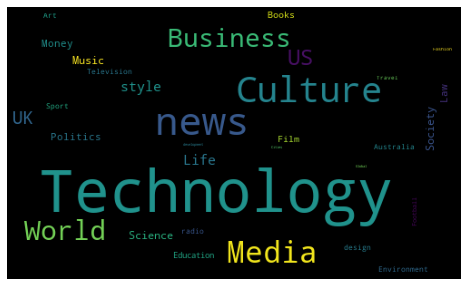

In [ ]:
display_word_cloud(maindf['topics_str'].values)

# Most common words in 'article' type

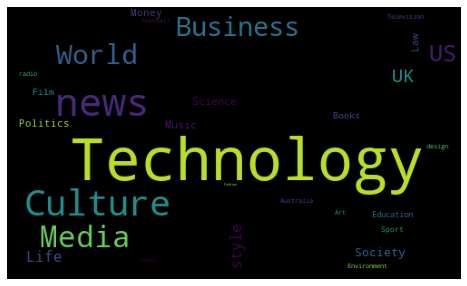

In [ ]:
display_word_cloud(maindf[maindf.type=='article']['topics_str'].values)

# Most common words in 'video' type

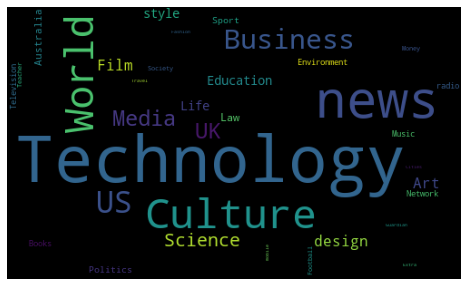

In [ ]:
display_word_cloud(maindf[maindf.type=='video']['topics_str'].values)

# Most common topics in 'audio' type

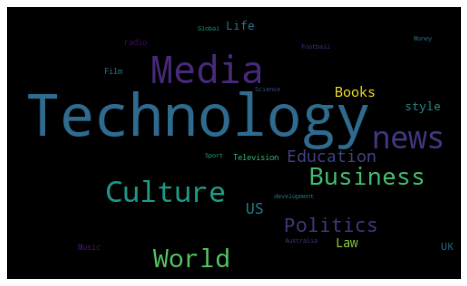

In [ ]:
display_word_cloud(maindf[maindf.type=='audio']['topics_str'].values)

# Most common topics in 'gallery' type

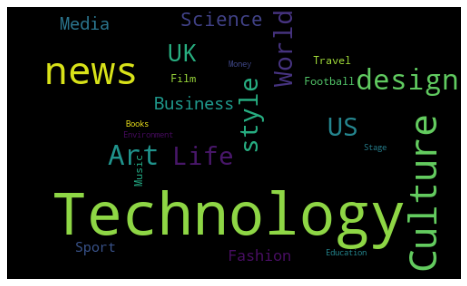

In [ ]:
display_word_cloud(maindf[maindf.type=='gallery']['topics_str'].values)

# Most common topics in 'liveblog' type

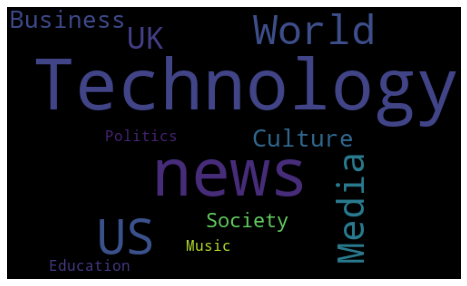

In [ ]:
display_word_cloud(maindf[maindf.type=='liveblog']['topics_str'].values)

# Most common webTitle values observed amongst data samples

In [ ]:
maindf['webTitle_str'] = maindf['webTitle'].astype(str).str.replace('\[|\]|\'', '')

In [ ]:
maindf['webTitlelen'] = maindf['webTitle'].apply(lambda x : len(x))

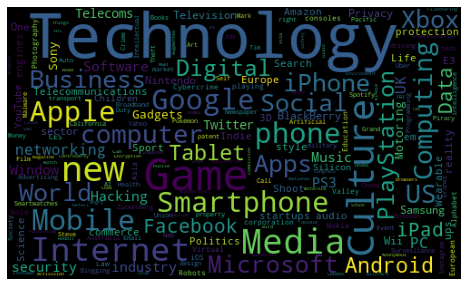

In [ ]:
display_word_cloud(maindf['webTitle_str'].values)

# Tokenize and count topic occurrence
CountVectorizer - converts a collection of text documents to a vector of term/token counts

In [ ]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '),binary='true')
multilabel_y = vectorizer.fit_transform(maindf['topics_str'])

In [ ]:
multilabel_y

<20161x41 sparse matrix of type '<class 'numpy.int64'>'
	with 43730 stored elements in Compressed Sparse Row format>

In [ ]:
multilabel_y[0:2].todense()

matrix([[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]])

# How many different tags/topics and what are they?
- 41 tags
- topics like technology, culture, business, etc.

In [ ]:
tags = vectorizer.get_feature_names()
tags[:10]

['art and design',
 'australia news',
 'books',
 'business',
 'cities',
 'culture',
 'education',
 'environment',
 'extra',
 'fashion']

In [ ]:
print(len(tags))

41


# What are the most frequent/popular tags?


In [ ]:
freqs = multilabel_y.sum(axis=0).A1
result = dict(zip(tags,freqs))

In [ ]:
tag_df = pd.DataFrame(result.items(), columns=["Tags", "Counts"])
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted["Counts"].values

In [ ]:
fig = px.bar(x=tag_df_sorted.Tags.values, y=tag_df_sorted.Counts.values)
fig.update_layout(yaxis_title="Number of articles the tag appears in",xaxis_title='Tag Name',title_text='Top Tags')
fig.show()

# To Predict Tags for each article

- Of the 41 different tags, I attempt to simplify the problem and use just top 3 most frequent tags for the purposes of predicting document/news-article tags

- Why 3 and not any other number higher or lower? - 99.9% of the articles are explained with just 3 tags as there are predominantly Technology articles. How we observed this is shown in this section

In [ ]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0] # sum of each column
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def articles_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
articlesexplained = []
total_tags = multilabel_y.shape[1] #no of tags
total_articles = multilabel_y.shape[0] # no of articles

for i in range(1,total_tags):
    #print(i)
    articlesexplained.append(np.round(((total_articles-articles_explained_fn(i))/total_articles)*100,3))

In [ ]:
fig = go.Figure(data=go.Scatter(x=np.arange(0,42), y=articlesexplained))
fig.update_layout(yaxis_title="Percentage of articles explained",xaxis_title='Number of tags used',title_text='How many tags do we really need?')
fig.show()

In [ ]:
# we will be taking 3 tags due to limitation in compute power
multilabel_yx = tags_to_choose(3)
print("number of questions that are not covered :", articles_explained_fn(3),"out of ", total_articles)

number of questions that are not covered : 24 out of  20161


In [ ]:
multilabel_yx.get_shape()

(20161, 3)

In [ ]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",np.round((multilabel_yx.shape[1]/multilabel_y.shape[1]),3)*100,"%)")

Number of tags in sample : 41
number of tags taken : 3 ( 7.3 %)


# Train-test split

In [ ]:
preprocessed_data = maindf[['Body_cleaned']]

In [ ]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (16128, 3)
Number of data points in test data : (4033, 3)


In [ ]:
y_test.sum(axis=0).tolist()[0]
# Test set has 4024 articles with Technology tag, 1037 articles with Culture tag and 806 articles with media tag. These are not mutually exclusive and overlapping cases would be present.

[4022, 911, 722]

In [ ]:
y_test.toarray()

array([[1, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

# Get TF-IDF features

- With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores.

- With Tfidfvectorizer on the contrary, you will do all three steps at once. Under the hood, it computes the word counts, IDF values, and Tf-idf scores all using the same dataset.

In [ ]:
tfidf_vect = TfidfVectorizer(min_df=0.00009,max_features=200000,smooth_idf=True,norm='l2',\
               tokenizer=lambda x : x.split(),sublinear_tf=False, ngram_range=(1,3) )

In [ ]:
x_train_vectors = tfidf_vect.fit_transform(x_train['Body_cleaned'])
x_test_vectors = tfidf_vect.transform(x_test['Body_cleaned'])

In [ ]:
#x_train_vectors[0:2].todense()

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_vectors,y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l1',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=-1)

In [ ]:
predictions = classifier.predict(x_test_vectors)

In [ ]:
print("accuracy ", metrics.accuracy_score(y_test,predictions))
print("macro f1 score ",metrics.f1_score(y_test,predictions, average='macro'))
print("micro f1 score ", metrics.f1_score(y_test, predictions, average='micro'))
print("hamming loss ", metrics.hamming_loss(y_test,predictions))


accuracy  0.8118026283163898
macro f1 score  0.8204814807571276
micro f1 score  0.9268511861969806
hamming loss  0.0672782874617737


# Data prep for deep learning

In [ ]:
multilabelycols = maindf['topics'].str.join('|').str.get_dummies()[['Technology','Culture','Media']]

In [ ]:
usedf = maindf.join(multilabelycols)
usedf = usedf[['Body_cleaned','Technology',	'Culture',	'Media']]

In [ ]:
usedf.head()

,Body_cleaned,Technology,Culture,Media
0,It is the corporate version of a yard sale. T...,1,1,0
1,"Startlingly, the last few years of writing abo...",1,0,1
2,Sony Computer Entertainment has been fined a r...,1,1,0
3,Apologies for the late running of chatterbox t...,1,1,0
4,"A quick burst of 9 links for you to chew over,...",1,0,0


In [ ]:
total_size=usedf.shape[0]
train_size=int(0.80*total_size)

train=usedf.head(train_size)
test=usedf.tail(total_size - train_size)


# Deep Learning approach using fastai
- approach followed is ULMFit
- i.e first fine-tune using a language model and then train for multi-label classification

### TextList.from_df - method includes tokenizer and numericalizer

### Two main data objects in PyTorch - DataSet and DataLoader
-  DataSet - contains all data samples/items together with their associated labels. 
- DataLoader - feeds chunks of these or batches of these to the model

### DataBunch 
- called a ‘bunch’ because it bunches together several PyTorch classes into one. For a typical supervised learning problem we will want a ‘training set’ and a ‘validation set’, with a separateDataSet and DataLoader for each. All of these are bundled up into the fastai DataBunch!
- it is the data-containing object that we need to feed to a neural network 

In [ ]:
# Create databunch
data = (TextList.from_df(train, cols='Body_cleaned')   #Where are the text? Column 'Body_cleaned' of dataframe
                .split_by_rand_pct(0.2) # split randomly with the default 20% in valid
                .label_for_lm()   #Label it for a language model
                .databunch(bs=48)) #convert to a DataBunch
data.show_batch() 

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



idx,text
0,"bankruptcy in xxmaj december and had hoped for a quick buy - out courtesy of the private equity firm , xxmaj xxunk xxmaj capital xxmaj group . xxmaj however , investors objected to the deal , and a xxup us court found in their favour , arguing that the company had not been aggressive enough in seeking other potential purchasers . xxmaj the alternative : an auction , held on"
1,"the distance between locations meant that , by the time you 'd heard about a particularly interesting gathering , it had already dispersed . sxswi is in danger of growing too big for its xxunk . xxmaj sure , the impact of the 2011 event will be felt as hundreds of new online products with a game layer are rushed to market , but the real innovators are already looking"
2,"for the xxup pc industry , because there will be this strong competitor and tablets will innovate like crazy and customers will decide which to buy . xxmaj there will be a strong xxup pc industry but tablets will be stronger in units . "" xxmaj he said he had begun using the original ipad before its launch in xxmaj january 2010 : "" xxmaj we had our [ window"
3,"rude health of the indie sector , the xxup pc is as important as ever . xxmaj last year 's xxup e3 was a bruising face - off ; this year 's could be a more intriguing competition , where the future of games comes sharply into focus . xxmaj so for now , here are the key trends and showdowns we 're expecting . playstation 4 vs xxmaj xbox"
4,"xxmaj the xxmaj birth of xxmaj tragedy ( 1872 ) . xxmaj he suffered a mental collapse in 1889 as well as a number of strokes in later years that left him unable to speak or walk before his death in xxmaj august 1900 at the age of 55 . xxbos xxmaj ross xxmaj ulbricht , the 29-year - old xxmaj san xxmaj francisco man accused of running the"


### language_model_learner 

- Create a Learner or an entitiy to create(using specified architecture) and train a language model from data 
- AWD_LSTM - architecture proposed and detailed in https://arxiv.org/pdf/1708.02182.pdf. Speciality - uses DropConnect regularization(dropout on hidden to hidden weights). Can use Transformer or TransformerXL instead
- drop_mult is applied to all the dropouts weights of the config
- Default loss function - cross entropy loss


In [ ]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)
#learn.model = learn.model.cuda()
# select the appropriate learning rate
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### We see the loss being quite stagnant until 1e-01 because there isn't much to learn; we're only fine-tuning

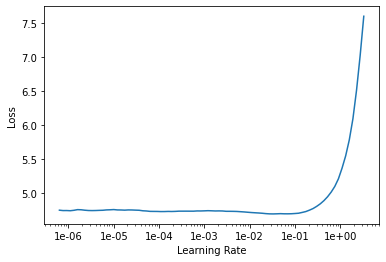

In [ ]:
# we typically find the point where the slope is steepest

learn.recorder.plot()

In [ ]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) #moms - momentum 
learn.save_encoder('fine_tuned_enc')


epoch,train_loss,valid_loss,accuracy,time
0,4.198510,3.992595,0.304886,18:54


In [ ]:

label_cols = ['Technology',	'Culture',	'Media']

test_datalist = TextList.from_df(test, cols='Body_cleaned', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='Body_cleaned', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos xxmaj in the third chapter of his xxmaj history of the xxmaj decline and xxmaj fall of the xxmaj roman xxmaj empire , xxmaj edward xxmaj gibbon gave two reasons why the slavery into which the xxmaj romans had tumbled under xxmaj augustus and his successors left them more wretched than any previous human slavery . xxmaj in the first place , xxmaj gibbon said , the xxmaj romans",Technology;Media
"xxbos xxmaj every week in xxmaj london , 30,000 people download xxmaj uber to their phones and order a car for the first time . xxmaj the technology company , which is worth $ 60bn , calls this moment “ conversion ” . xxmaj uber has deployed its ride - hailing platform in 400 cities around the world since its launch in xxmaj san xxmaj francisco on 31 xxmaj may",Technology
"xxbos xxmaj whatever happened to wonder ? xxmaj the most unnerving thing about sitting in the back of a driverless car is how quickly you get used to it . xxmaj after 10 minutes cruising xxmaj californian streets in the rear seat of one of xxmaj google ’s “ autonomous ” xxmaj lexus 4x4s , the “ look , no hands ! ” miracle of the xxmaj google “ driver",Technology
"xxbos xxunk xxup bst xxmaj summary xxmaj after three hours and 30 minutes of mapping , xxunk and fake xxmaj jon xxmaj xxunk sightings , xxmaj google 's annual i / o developer conference has come to an end . xxmaj here is a summary of xxmaj google 's major announcements : • xxmaj google xxmaj play xxmaj music xxmaj all xxmaj access : xxmaj the company finally",Technology
"xxbos xxmaj the alarm went off at 6 am to kickstart our journey , and i was full of trepidation . xxmaj driving 706 km ( 439 miles ) in a car with three other adults and enough luggage for a week ’s holiday might already feel like a modern labour of xxmaj hercules for some , but this trip had an extra challenge : the car would be all",Technology


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


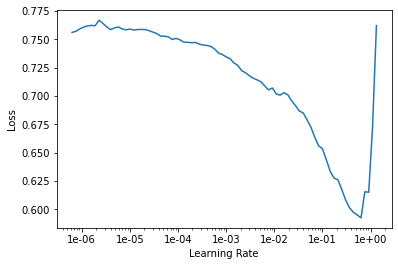

In [ ]:

learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
#learn_classifier.model = learn_classifier.model.cuda()

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()



In [ ]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 3e-2, moms=(0.8,0.7))

learn_classifier.show_results()

epoch,train_loss,valid_loss,time
0,0.244617,0.204511,05:26
1,0.253625,0.209242,05:50
2,0.237379,0.197192,04:42
3,0.215412,0.182397,04:44
4,0.201143,0.195402,05:22


text,target,prediction
"xxbos xxunk xxup bst xxup ios 8 also fixes a number of security flaws , which is good news if you do n’t like security flaws – but not so good if you ’ve decided to hold off on the update . xxmaj the company ’s disclosed 53 vulnerabilities which are fixed in the new version of the operating system , which let attackers do anything from run code on",Technology;Media,Technology
"xxbos a short , handsome man bounces outside the colossal courthouse on xxmaj walnut xxmaj street , xxmaj newark , xxmaj new xxmaj jersey . xxmaj he 's doing it to keep warm – it is freezing today – and also because he 's fired up . xxmaj his name is xxmaj andrew xxmaj auernheimer , but he 's known across the internet as "" weev "" . xxmaj his",Technology,Technology;Media
"xxbos xxmaj the release of xxmaj apple 's next revision of xxmaj mac xxup osx , version 10.7 – called "" xxmaj lion "" – brings a number of big and small changes , from the direction of scrolling to the colour of buttons to ad - hoc xxmaj wi - xxmaj fi sharing . xxmaj here to guide you through them and tell you what 's good , what",Technology,Technology
"xxbos xxmaj until recently , virtual reality had been something of a fantasy for storytellers and technologists . xxmaj as long ago as 1935 , xxmaj american science fiction writer xxmaj stanley g xxmaj xxunk described something like virtual reality in a short story called xxmaj xxunk ’s xxmaj spectacles . “ xxmaj but listen – a movie that gives one sight and sound . xxmaj suppose now i add",Technology;Culture;Media,Technology;Culture;Media
"xxbos xxmaj following xxmaj eric xxmaj schmidt 's remark to xxmaj kara xxmaj swisher in xxmaj october that he would n't comment on the smartphone patent wars because he "" does n't understand all the details "" , we 'd like to be of service . xxmaj yes , xxmaj eric xxmaj schmidt is far smarter than me , and probably than anyone reading this piece ( unless your name",Technology,Technology


In [ ]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()
labels = np.argmax(labels, 1)


In [ ]:
target = test[['Technology',	'Culture',	'Media']].values

In [ ]:
thresh = 0.5
labelled_preds = [', '.join([learn_classifier.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[0:5]


['Technology, Culture',
 'Technology, Culture',
 'Technology',
 'Technology, Culture',
 'Technology']

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    targ = torch.from_numpy(targ)
    #print(type(targ))
    return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
accuracy_multi(preds,target,thresh=0.5,sigmoid=False)

tensor(0.9130)

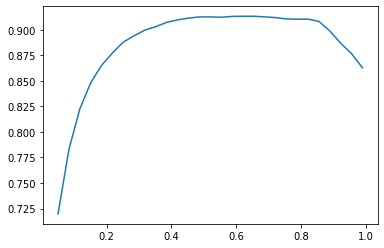

In [ ]:
xs = torch.linspace(0.05,0.99,29)
accs = [accuracy_multi(preds,target,thresh=i,sigmoid=False) for i in xs]
plt.plot(xs,accs)
plt.show()